# Balanced random forest model with balanced accuracy score

We use the balanced random forest model maximizing the balanced accuracy, i.e. the average of the recall of each class, in the grid search. The balanced Random Forest model is implemented in the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) software package.

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

## Some variables

In [2]:
datapath = '/data/ml_course/05_Capstone_project/rf_data/'
model_name = 'balanced_RF_balanced_accuracy.pickle'
test_size = 0.1 # 10% of points used for testing
val_size = 0.1  # 10% of points (after removing test points) used for validation
n_splits = 5  # number of splits in folding
n_estimators = np.r_[np.arange(1, 21, 2), np.arange(20, 60, 10)]  # number of trees

features = ['HRV_norm', 'HRV_norm_text', 'IR_108', 'IR_108_text', 'WV_062-IR_108', 'WV_062-IR_108_text']
nfeatures = len(features)

In [3]:
# suppress anoying iypthon warnings. Not ideal since we suppress also potentially relevant warnings
#import warnings
#warnings.filterwarnings('ignore')

## Load data

In [4]:
years = ['2018', '2019', '2020']
months = ['04', '05', '06', '07', '08', '09']

for year in years:
    for month in months:
        print(year+month, end="\r", flush=True)
        fname = datapath+year+month+'_data.npz'
        if not os.path.isfile(fname):
            continue
        
        X = None
        with np.load(fname, allow_pickle=False) as npz_file:
            # Load the arrays
            if X is None:
                X = npz_file['features']
                y = npz_file['targets']
            else:
                X = np.concatenate((X, npz_file['features']), axis=0)
                y = np.concatenate((y, npz_file['targets']), axis=0)

In [5]:
print('features matrix shape:', X.shape)
print('target matrix shape:', y.shape)

features matrix shape: (7435724, 6)
target matrix shape: (7435724,)


In [6]:
# Remove NaNs
# NaNs can appear in texture fields.
# They could safely be considered 0s but we remove them
ind_row, ind_col = np.where(np.isnan(X))
X = np.delete(X, ind_row, axis=0)
y = np.delete(y, ind_row, axis=0)

In [7]:
print('features matrix shape:', X.shape)
print('target matrix shape:', y.shape)

features matrix shape: (7432290, 6)
target matrix shape: (7432290,)


In [8]:
# Group together 0 (No POH was computed) and 1 (POH below 90%)
np.unique(y)
y[y == 1] = 0
y[y == 2] = 1
np.unique(y)

array([0, 1], dtype=int8)

In [9]:
npixels = y.size
npixels_hail = y[y==1].size

print('npixels:', npixels)
print('npixels with hail:', npixels_hail)
print('% of pixels with hail:', npixels_hail/npixels*100)

npixels: 7432290
npixels with hail: 61171
% of pixels with hail: 0.8230437725115678


## Split data into test and training

In [10]:
# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=0)

In [11]:
print('features matrix for training shape:', X_tr.shape)
print('target matrix for training shape:', y_tr.shape)

features matrix for training shape: (6689061, 6)
target matrix for training shape: (6689061,)


## Prepare data folds

In [12]:
ss = ShuffleSplit(n_splits=n_splits, test_size=val_size, random_state=0)
ss.get_n_splits()

5

## Random Forest

In [13]:
# Create pipeline
# Balanced random forest
pipe_RF = Pipeline([
    ('scaler', None),
    ('RF', BalancedRandomForestClassifier(random_state=0, max_depth=None))
])

# Create cross-validation object
grid_RF = {'RF__n_estimators': n_estimators}

grid_RF_cv = GridSearchCV(pipe_RF, grid_RF, scoring='balanced_accuracy', cv=ss, return_train_score=True, verbose=True, n_jobs=-1)

# Fit estimator
grid_RF_cv.fit(X_tr, y_tr)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 27.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.1, train_size=None),
             estimator=Pipeline(steps=[('scaler', None),
                                       ('RF',
                                        BalancedRandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'RF__n_estimators': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 20, 30, 40, 50])},
             return_train_score=True, scoring='balanced_accuracy',
             verbose=True)

## Evaluate model

In [14]:
# Collect results in a DataFrame
RF_results = pd.DataFrame({
    'trees': grid_RF_cv.cv_results_['param_RF__n_estimators'],
    'mean_tr': grid_RF_cv.cv_results_['mean_train_score'],
    'mean_te': grid_RF_cv.cv_results_['mean_test_score'],
    'std_te': grid_RF_cv.cv_results_['std_test_score']
})

In [15]:
grid_RF_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_RF__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

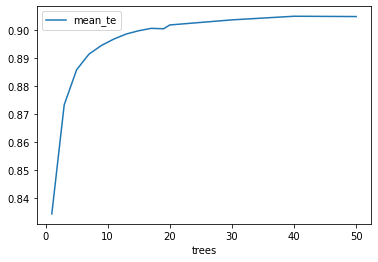

In [16]:
# Plot test curve
RF_results.plot(x='trees', y='mean_te')
plt.show()

In [17]:
# Ten best combinations according to the mean test score
RF_results.sort_values(by='mean_te', ascending=False).head(10)

,trees,mean_tr,mean_te,std_te
12,40,0.931180,0.904946,0.001739
13,50,0.930777,0.904835,0.001492
11,30,0.931807,0.903650,0.001831
10,20,0.932786,0.901838,0.002367
8,17,0.928165,0.900631,0.002120
9,19,0.928291,0.900477,0.002057
7,15,0.927913,0.899779,0.002007
6,13,0.927432,0.898618,0.002171
5,11,0.926978,0.896824,0.001588
4,9,0.926059,0.894534,0.002466


In [18]:
# Report test score
acc_RF = 100*grid_RF_cv.score(X_te, y_te)
print('Test accuracy: {:.2f}%'.format(acc_RF))

Test accuracy: 90.77%


In [19]:
y_pred = grid_RF_cv.predict(X_te)

In [20]:
tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

In [21]:
print('True positive: ', tp)
print('True negative: ', tn)
print('False positive: ', fp)
print('False negative: ', fn)
print('Positive pixels: ', y_te[y_te == 1].size)
print('Negative pixels: ', y_te[y_te == 0].size)

True positive:  5782
True negative:  635883
False positive:  101278
False negative:  286
Positive pixels:  6068
Negative pixels:  737161


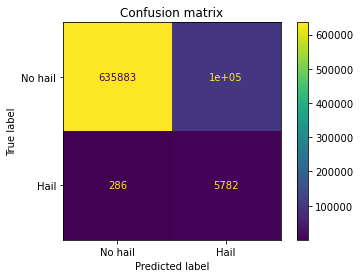

In [22]:
disp = plot_confusion_matrix(grid_RF_cv, X_te, y_te, labels=[0, 1], display_labels=['No hail', 'Hail'], normalize=None)
disp.ax_.set_title('Confusion matrix')
plt.show()

In [23]:
pod = 100*tp/(tp+fn)
far = 100*fp/(fp+tn)
ppv = tp/(tp+fp)
print('Probability of Detection (POD):', pod)
print('False Alarm Rate (FAR):', far)
print('Positive Predictive Value (PPV):', ppv)

Probability of Detection (POD): 95.28675016479895
False Alarm Rate (FAR): 13.738925417920916
Positive Predictive Value (PPV): 0.05400709882308986


There is a significant improvement of the results when using the balanced accuracy as target.

## Save best model

In [24]:
with open(model_name, 'wb') as bfile: 
    s = pickle.dump(grid_RF_cv.best_estimator_, bfile)

In [25]:
with open(model_name, 'rb') as bfile:
    rf_model_best = pickle.load(bfile)

## Get features importance

In [26]:
f_importance = rf_model_best['RF'].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_best['RF'].estimators_], axis=0)
inds = np.argsort(f_importance)[::-1]
f_importance_ordered = f_importance[inds]
features_ordered = np.array(features)[inds]

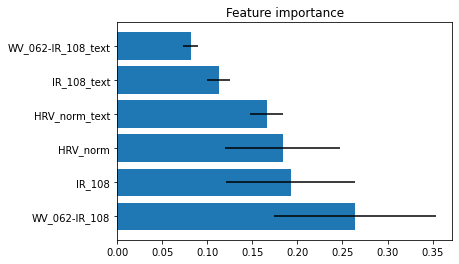

In [27]:
plt.barh(np.arange(nfeatures), f_importance_ordered, xerr=std[inds], align="center")
plt.yticks(np.arange(nfeatures), features_ordered)
plt.title('Feature importance')
plt.show()